In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

#### Extract license plate from sample _Plate_examples/germany_car_plate.jpg_  

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

#test_image_path = "test_2.jpg"
image_paths = glob.glob("Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

Found 18 images...


In [5]:
def pull_plate(index, path):
    try:
        vehicle, LpImg, cor = get_plate(path)
    except AssertionError as e:
        print(f'error with image {index}: {e}\n{path}')
        return None

    fig = plt.figure(figsize=(12,6))
    grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
    fig.add_subplot(grid[0])
    plt.axis(False)
    plt.imshow(vehicle)
    grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
    fig.add_subplot(grid[1])
    plt.axis(False)
    plt.imshow(LpImg[0])
    return vehicle, LpImg, cor

In [11]:
def clean_lp_image(LpImg):
    if (len(LpImg)): #check if there is at least one license image
        # Scales, calculates absolute values, and converts the result to 8-bit.
        plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

        # convert to grayscale and blur the image
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Applied inversed thresh_binary 
        binary = cv2.threshold(blur, 180, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)


    # visualize results    
    fig = plt.figure(figsize=(12,7))
    plt.rcParams.update({"font.size":18})
    grid = gridspec.GridSpec(ncols=2,nrows=2,figure = fig)
    plot_image = [gray, blur, binary, thre_mor]
    plot_name = ["gray","blur","binary","dilation"]

    for i in range(len(plot_image)):
        fig.add_subplot(grid[i])
        plt.axis(False)
        plt.title(plot_name[i])
        if i ==0:
            plt.imshow(plot_image[i])
        else:
            plt.imshow(plot_image[i],cmap="gray")

    # plt.savefig("threshding.png", dpi=300)
    return plate_image, binary, thre_mor

In [7]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

In [17]:
def detect_letters(plate_image, binary, thre_mor):
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h / w

        # These two if-checks were throuwing away too many potential letters.
        if 0.75 <= ratio <= 10: # Only select contour with defined ratio, was 1 <= ratio <= 3.5 in the default code.
            if h / plate_image.shape[0] >= 0.20: # Select contour which has the height larger than 20% of the plate, was 50% in the default code

                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)

    print("Detect {} letters...".format(len(crop_characters)))
    fig = plt.figure(figsize=(10,6))
    plt.axis(False)
    plt.imshow(test_roi)
    #plt.savefig('grab_digit_contour.png',dpi=300)
    
    return crop_characters

In [15]:
def draw_binary_characters(crop_characters):
    fig = plt.figure(figsize=(14,4))
    grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

    for i in range(len(crop_characters)):
        fig.add_subplot(grid[i])
        plt.axis(False)
        plt.imshow(crop_characters[i],cmap="gray")
    #plt.savefig("segmented_leter.png",dpi=300)  
    return


looking at image 0, Plate_examples/russia_motor_plate.jpg...

Detect 8 letters...

looking at image 1, Plate_examples/china_car_plate.jpg...

Detect 0 letters...
error with this image Number of columns must be a positive integer, not 0

looking at image 2, Plate_examples/germany_car_plate.jpg...

Detect 8 letters...

looking at image 3, Plate_examples/india_motor_plate.jpg...

Detect 11 letters...

looking at image 4, Plate_examples/usa_motor_plate.jpg...

Detect 5 letters...

looking at image 5, Plate_examples/vietnam_car_rectangle_plate.jpg...

Detect 8 letters...


<ipython-input-5-8b7acc0bf717>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))



looking at image 6, Plate_examples/turkey_car_plate.jpg...

Detect 0 letters...
error with this image Number of columns must be a positive integer, not 0

looking at image 7, Plate_examples/russia_car_plate.jpg...

Detect 9 letters...

looking at image 8, Plate_examples/thailand_motor_plate.jpg...

Detect 13 letters...

looking at image 9, Plate_examples/china_motor_plate.jpg...

Detect 4 letters...

looking at image 10, Plate_examples/thailand_car_plate.jpg...

Detect 0 letters...
error with this image Number of columns must be a positive integer, not 0

looking at image 11, Plate_examples/koera_motor_plate.jpg...

Detect 9 letters...

looking at image 12, Plate_examples/koera_car_plate.jpg...

Detect 0 letters...
error with this image Number of columns must be a positive integer, not 0

looking at image 13, Plate_examples/india_car_plate.jpg...

Detect 10 letters...

looking at image 14, Plate_examples/vietnam_motor_plate.jpg...

Detect 9 letters...

looking at image 15, Plate_examp

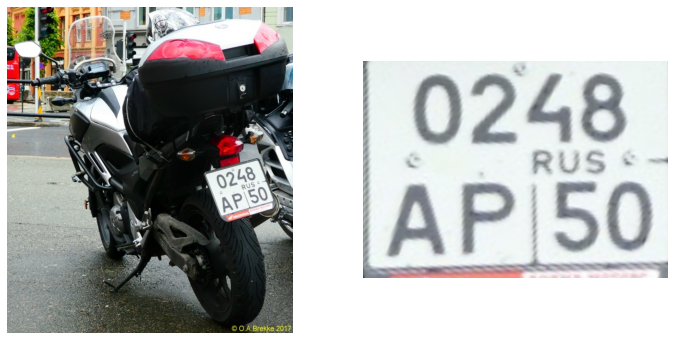

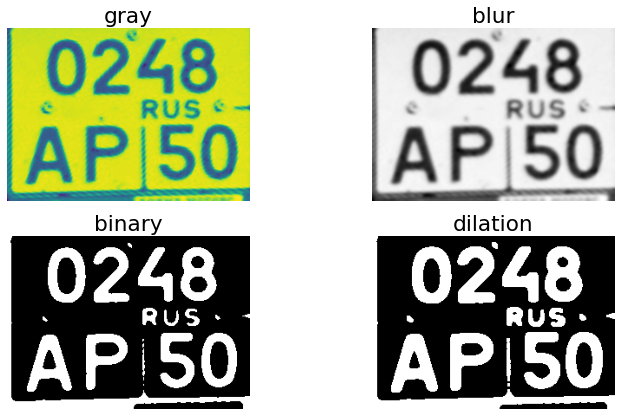

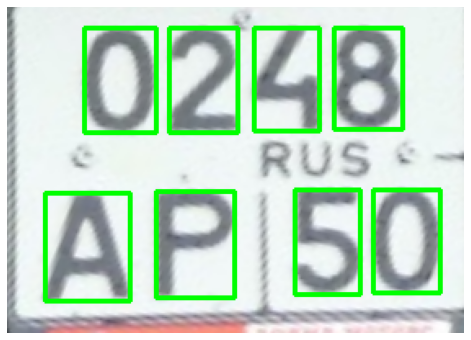

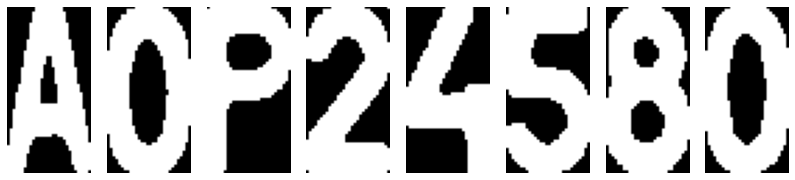

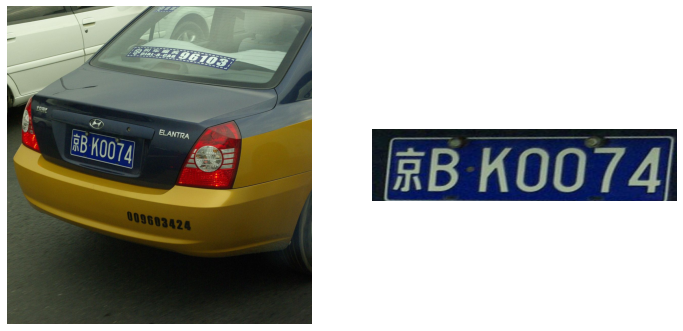

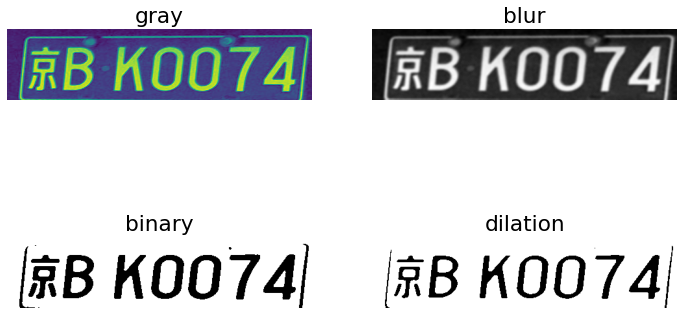

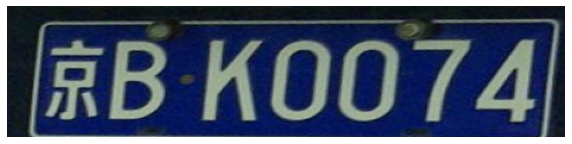

<Figure size 1008x288 with 0 Axes>

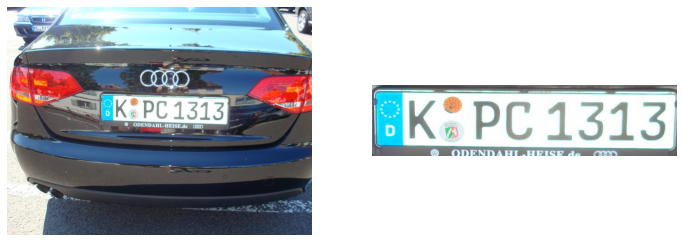

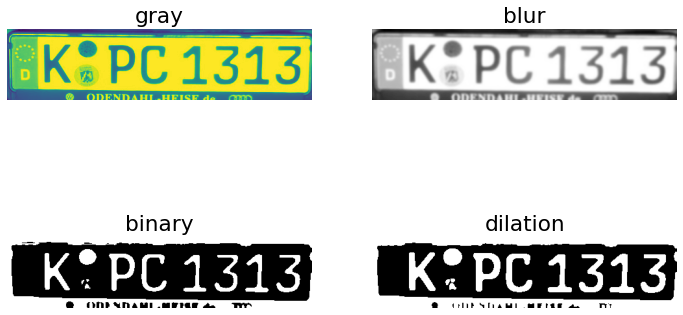

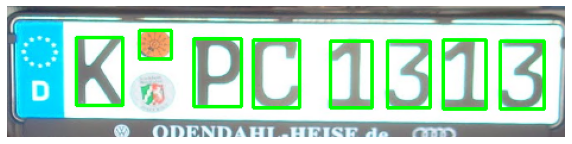

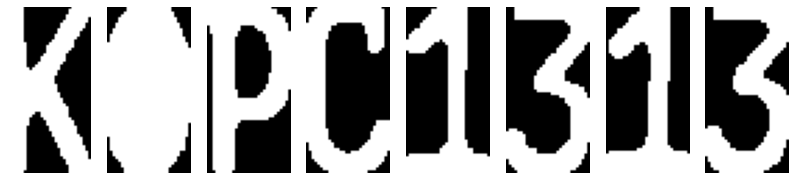

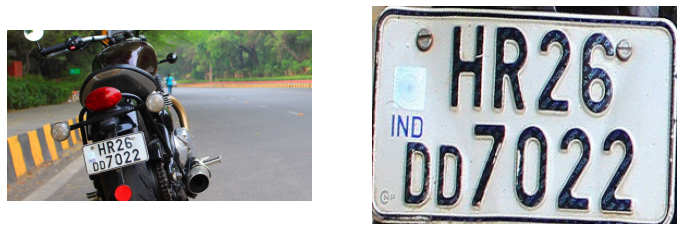

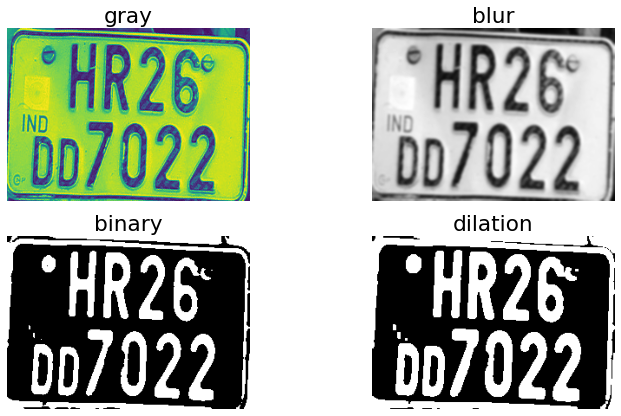

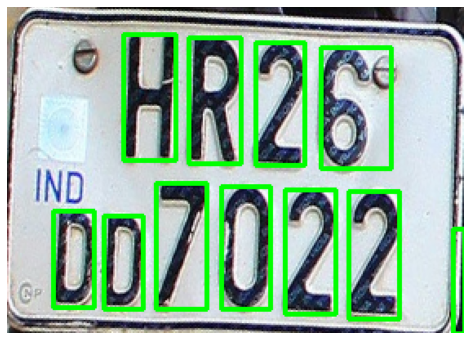

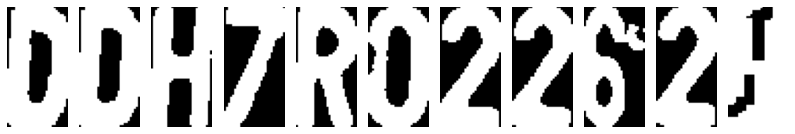

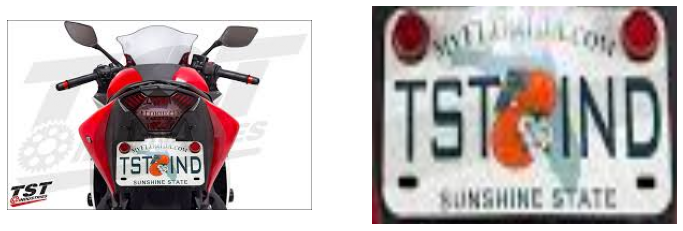

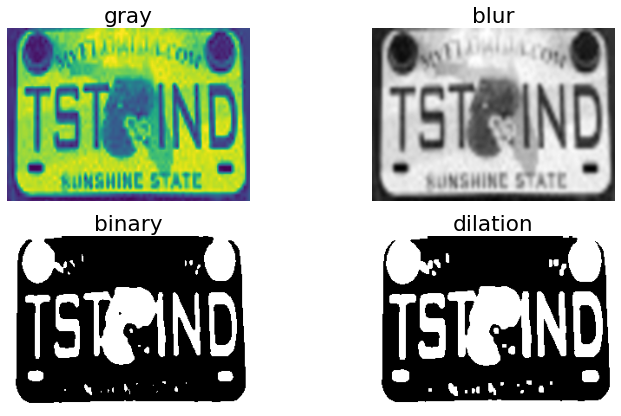

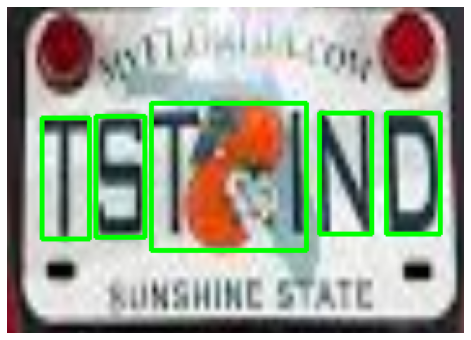

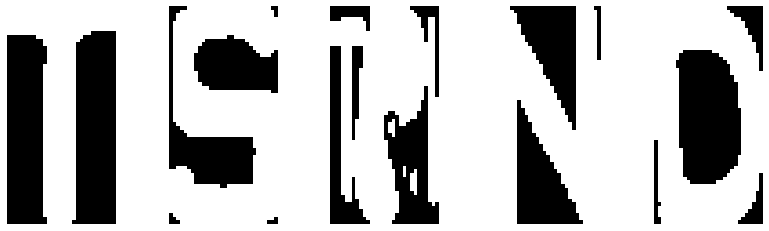

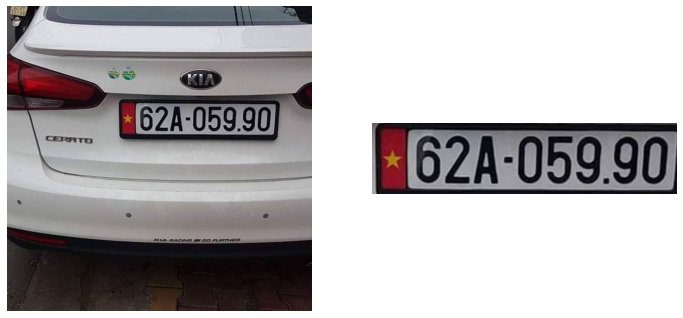

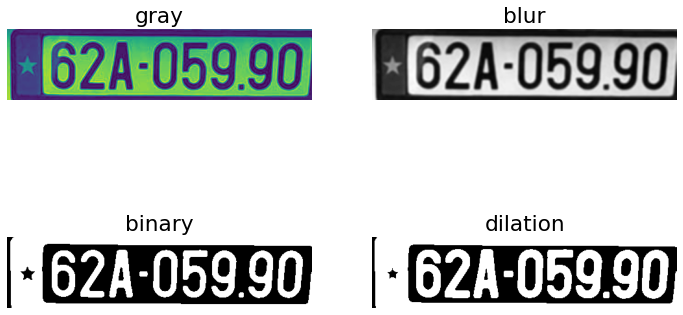

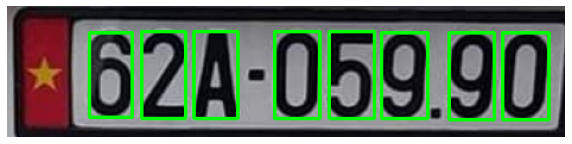

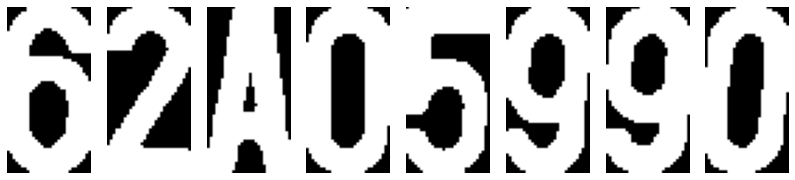

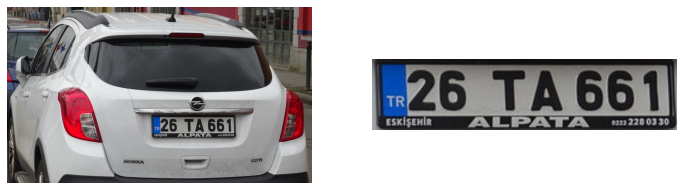

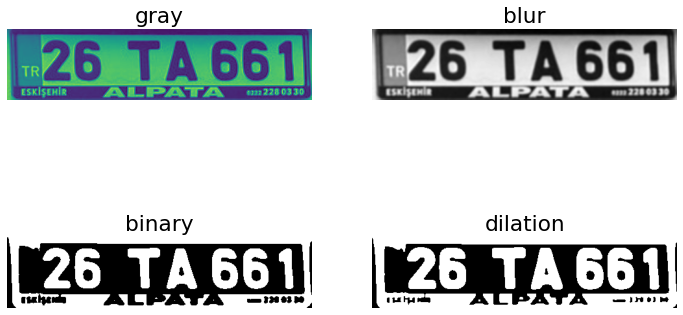

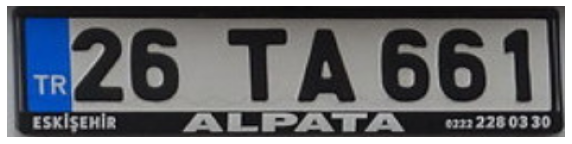

<Figure size 1008x288 with 0 Axes>

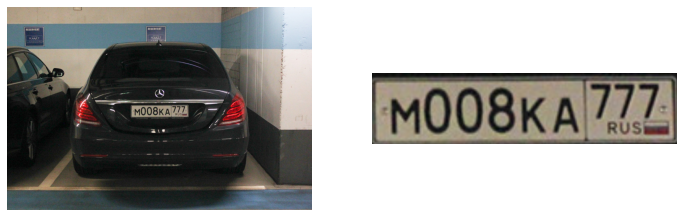

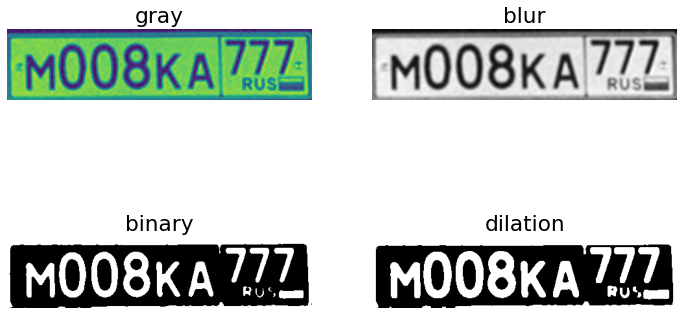

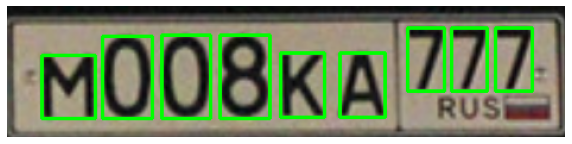

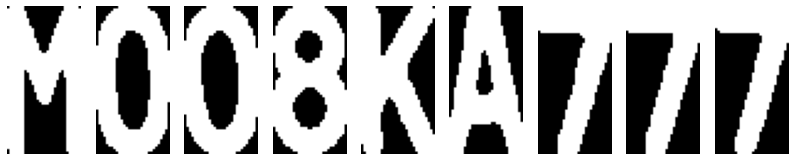

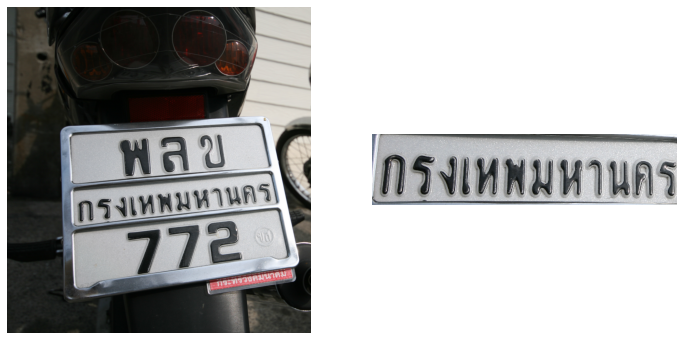

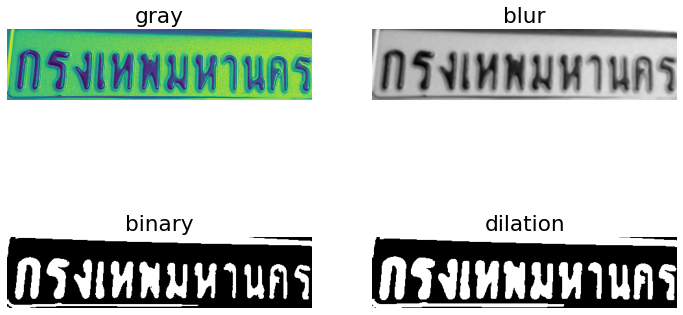

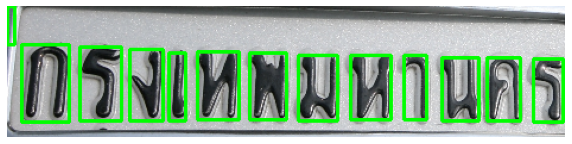

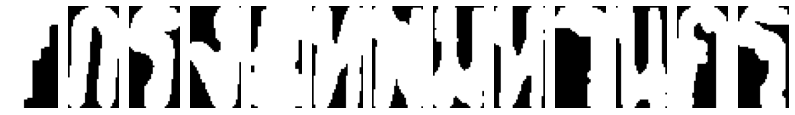

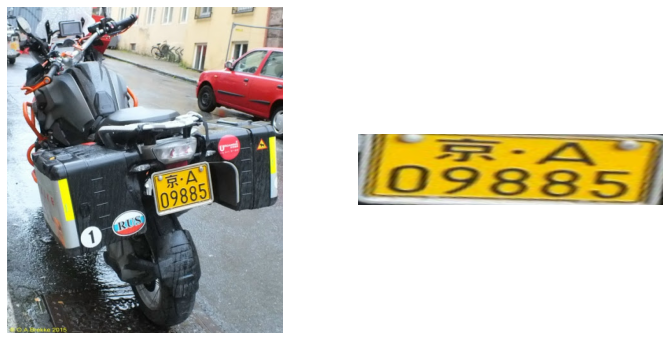

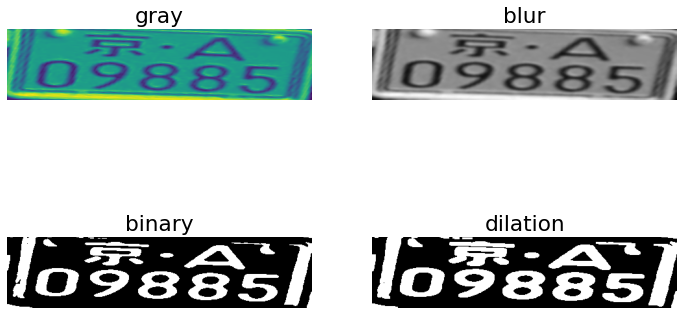

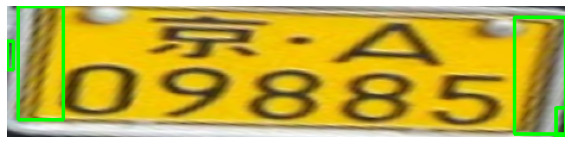

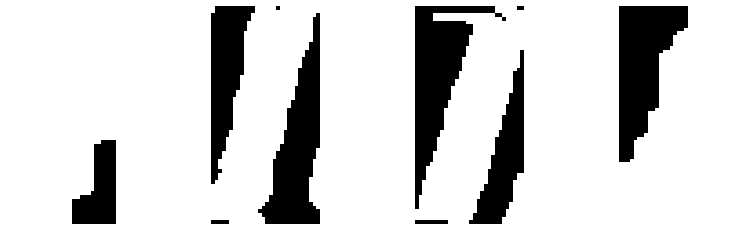

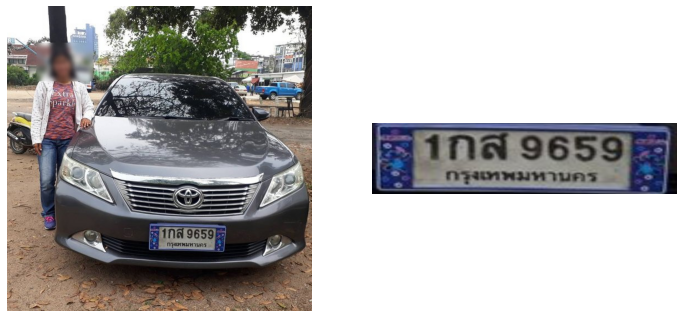

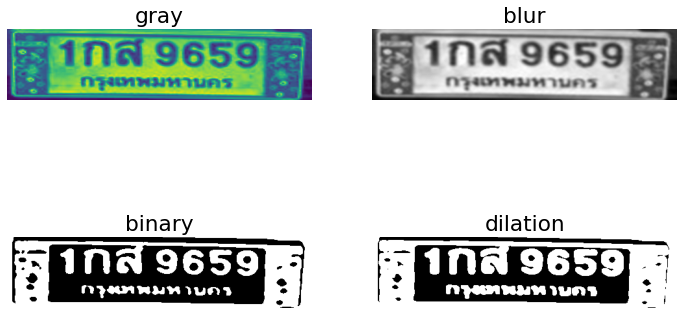

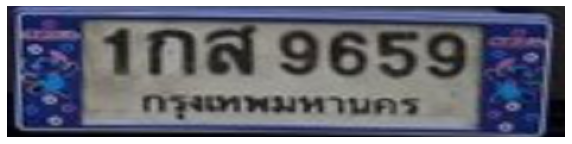

<Figure size 1008x288 with 0 Axes>

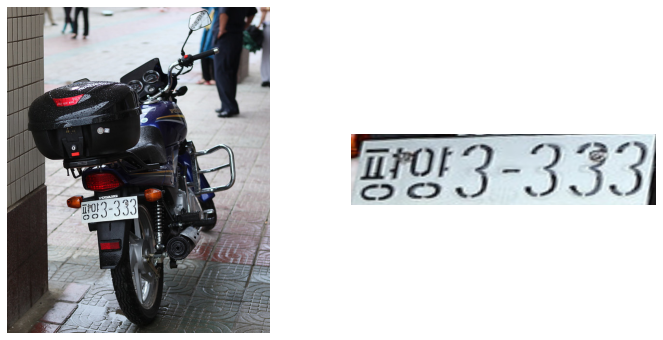

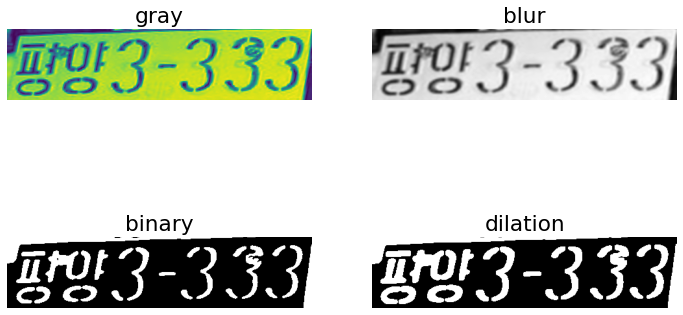

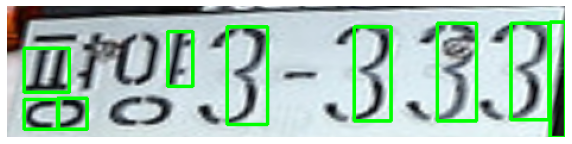

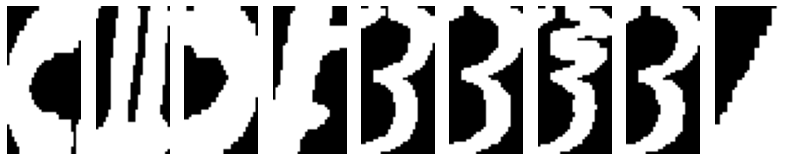

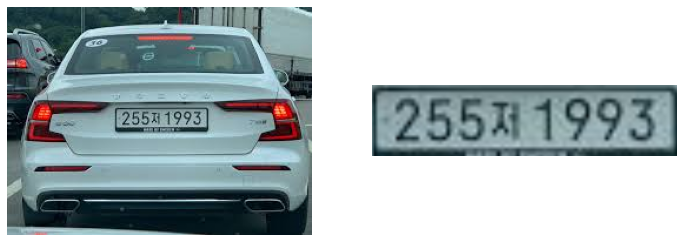

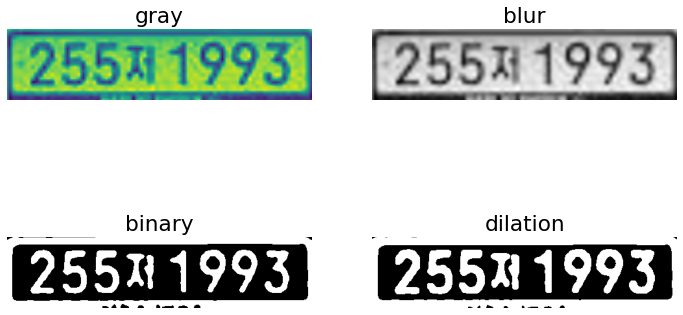

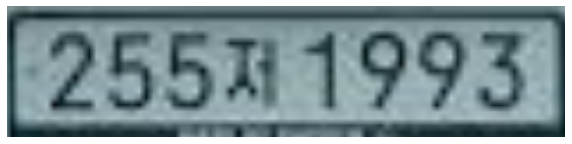

<Figure size 1008x288 with 0 Axes>

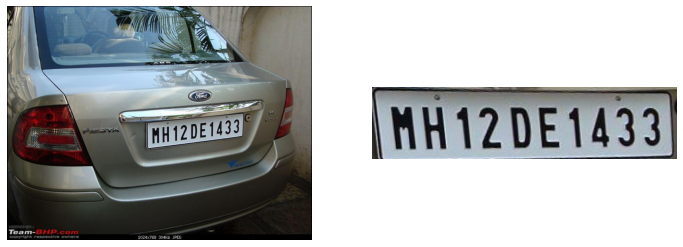

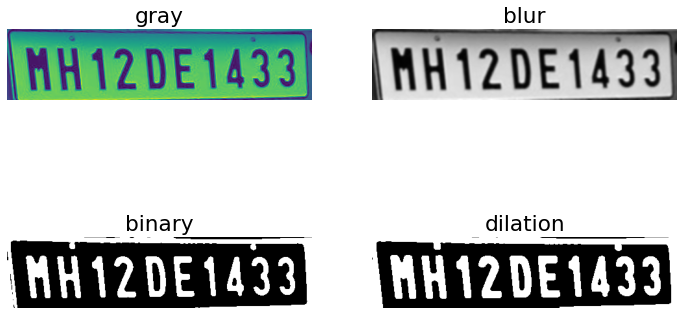

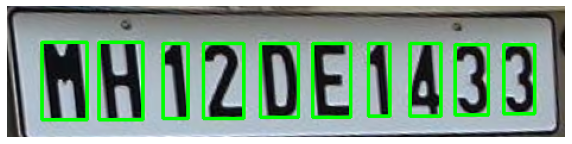

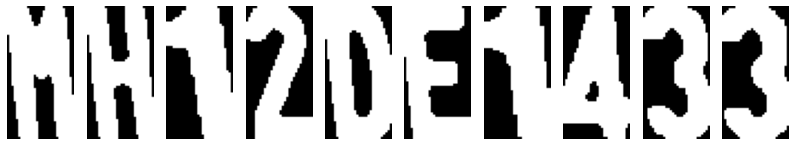

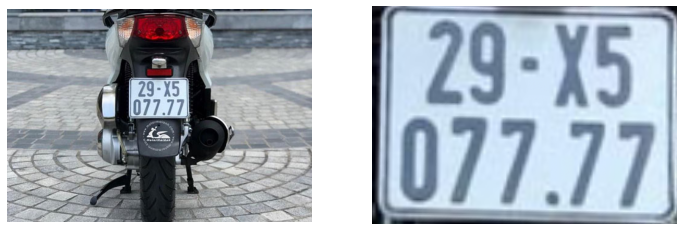

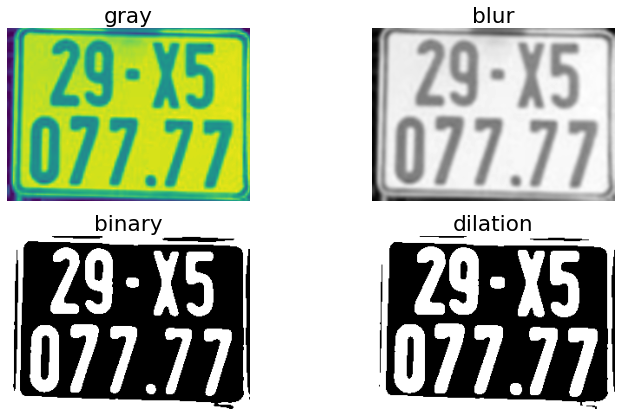

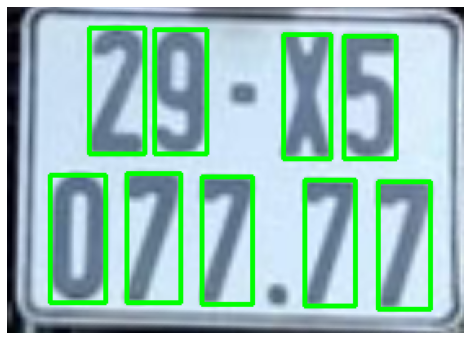

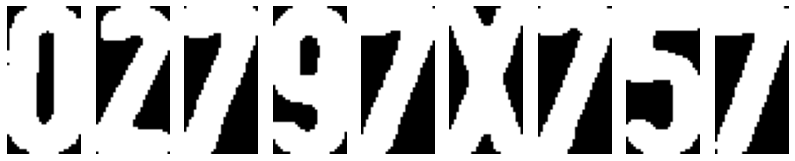

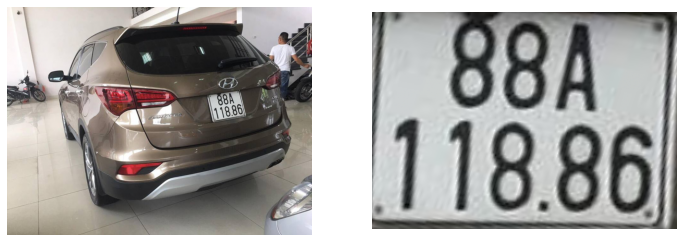

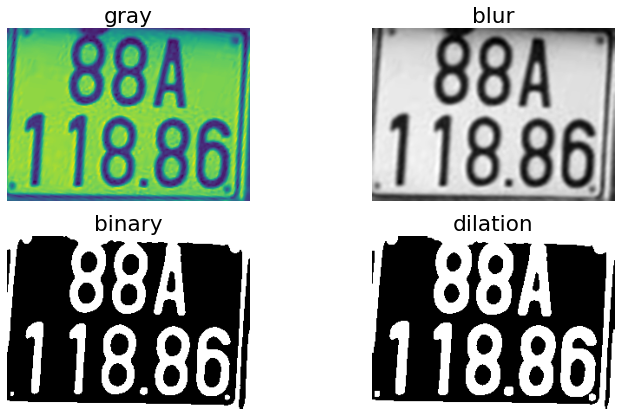

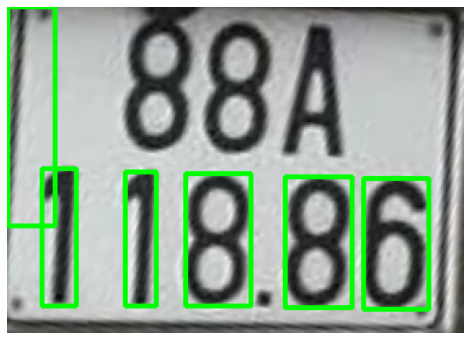

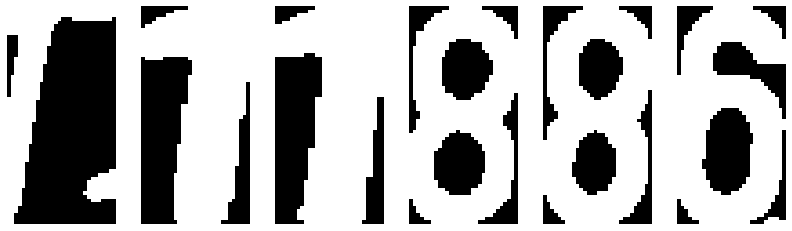

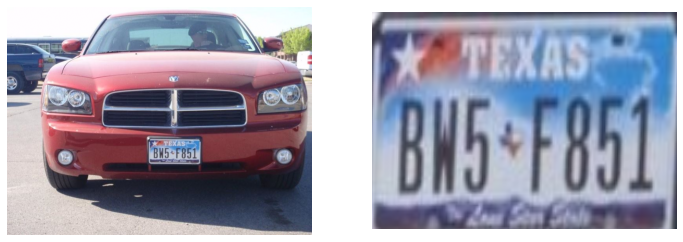

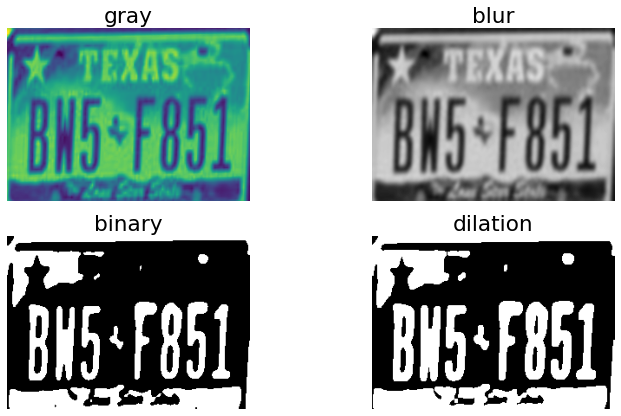

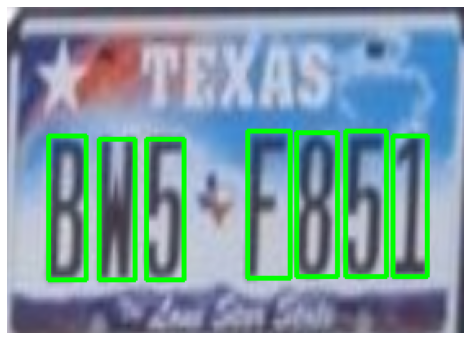

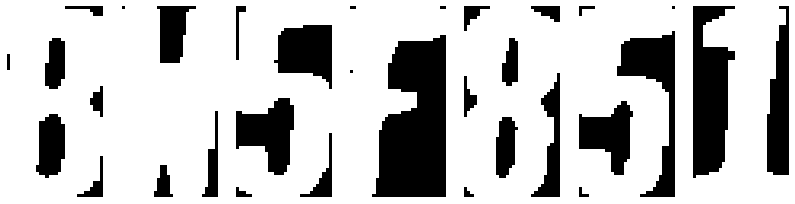

In [18]:
for i, img_path in enumerate(image_paths):
    print(f'\nlooking at image {i}, {img_path}...\n')
    try:
        vehicle, LpImg, cor = pull_plate(i, img_path)
        plate_image, binary, thre_mor = clean_lp_image(LpImg)
        crop_characters = detect_letters(plate_image, binary, thre_mor)
        draw_binary_characters(crop_characters)
    except Exception as e:
        print(f'error with this image {e}')
        continue

# The end!